In [20]:
import numpy as np
from scipy.stats import multivariate_normal, norm
import math
import matplotlib.pyplot as plt

Формула Блэка-Шоулза

### Формула для колл-опциона (Call Option):

$$ C = S_0 N(d_1) - K e^{-rT} N(d_2) $$

### Формула для пут-опциона (Put Option):

$$ P = K e^{-rT} N(-d_2) - S_0 N(-d_1) $$

### Где:

- $ C $ — цена колл-опциона.
- $ P $ — цена пут-опциона.
- $ S_0 $ — текущая цена базового актива.
- $ K $ — страйк-цена опциона.
- $ r $ — безрисковая ставка (годовая).
- $ T $ — срок до истечения опциона (в годах).
- $ N(\cdot) $ — кумулятивная функция стандартного нормального распределения.
- $ d_1 $ и $ d_2 $ — промежуточные переменные, вычисляемые следующим образом:

$$ d_1 = \frac{\ln\left(\frac{S_0}{K}\right) + \left(r + \frac{\sigma^2}{2}\right)T}{\sigma \sqrt{T}} $$

$$ d_2 = d_1 - \sigma \sqrt{T} $$

- $ \sigma $ — волатильность базового актива (годовая).

# 1 задание

В модели Мертона цена всех акций компании = стоимости собственного капитала компании.
Основываясь на предпосылках модели Мертона, мы предполагаем, что
1. Стоимость фирмы является логнормально распределенной случайной величиной, эволю-
ция которой описывается случайным процессом:
𝑑𝑉𝑡 / 𝑉𝑡 = 𝜇𝑑𝑡 + 𝜎𝑑𝑊𝑡
Копмания не выплачивает дивиденды. Начальная стоимость фирмы (𝑉𝑡) 100, волатиль-
ность 𝜎 = 0.3
2. У фирмы есть долговые обязательства: D = 70. Обязательства должны быть погашены
через 10 лет.
3. Безрисковая ставка является константой: 𝑟 = 4%

В данной модели стоимость собственного капитала (equity) - это остаочная стоимость фир-
мы после выплаты долга, т.е. через 10 лет стоимсть акций 𝑚𝑎𝑥(𝑉𝑇 − 𝐷; 0). Таким образом,
стоимость собственного капитала (equity) равна стоимости опциона колл на активы фирмы,
у которого страйк 𝐾 = 70 и датой экспирации 𝑇 = 10. Рассчитайте текущую стоимость собственного капитала компании.

In [4]:
def black_scholes_call(S, K, r, T, sigma):  
    """  
    Вычисление стоимости колл-опциона по формуле Блэка-Шоулза.  
  
    :param S: текущая цена базового актива  
    :param K: страйк-цена опциона  
    :param r: безрисковая ставка (годовая)  
    :param T: срок до истечения опциона (в годах)  
    :param sigma: волатильность базового актива (годовая)  
    :return: цена колл-опциона  
    """
    if T <= 0:
        return max(S - K, 0.0)
    
    d1 = (math.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T))  
    d2 = d1 - sigma * math.sqrt(T)  
  
    call_price = S * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)  
  
    return call_price 

In [9]:
S = 100  
K = 70   
r = 0.04  
T = 10    
sigma = 0.3

print(f"Текущая стоимость собственного капитала компании: {black_scholes_call(S, K, r, T, sigma):.2f}")

Текущая стоимость собственного капитала компании: 60.42


### Call on call option

In [13]:
def calculate_S_star(K1, K2, T1, T2, r, sigma, low=1e-6, high=1e6, tol=1e-8):
    """
    S^* - такая цена акции, при которой стоимость базового опциона (underlying option)
    равна K1 в момент времени T1

    Поиск осуществляется с помощью метода бисекции.
    """
    target = K1
    for _ in range(200):
        mid = 0.5 * (low + high)
        val = black_scholes_call(mid, K2, T2 - T1, r, sigma)
        if abs(val - target) < tol:
            return mid
        if val > target:
            high = mid
        else:
            low = mid
    return 0.5 * (low + high)


def compound_call_price(S, K1, K2, T1, T2, r, sigma, t=0):
    """Формулы из задания"""

    S_star = calculate_S_star(K1, K2, T1, T2, r, sigma)
    
    # a1, a2
    a1 = (
        np.log(S / S_star) + (r + 0.5 * sigma ** 2) * (T1 - t)
    ) / (
        sigma * np.sqrt(T1 - t)
    )
    a2 = a1 - sigma * np.sqrt(T1 - t)
    
    # b1, b2
    b1 = (
        np.log(S_star / K2) + (r + 0.5 * sigma ** 2) * (T2 - t)
    ) / (
        sigma * np.sqrt(T2 - t)
    )
    b2 = b1 - sigma * np.sqrt(T2 - t)

    # rho
    rho = np.sqrt((T1 - t) / (T2 - t))
    mean = [0, 0]
    cov = [[1, rho],[rho, 1]]
    norm2d = multivariate_normal(mean, cov).cdf

    price = (
        S * norm2d([a1, b1])
        - K2 * np.exp(-r * (T2 - t)) * norm2d([a2, b2]) 
        - K1 * np.exp(-r * (T1 - t)) * norm.cdf(a2)
    )
    return price

Генерируем сетку параметров и считаем цену сложного опциона

In [29]:
V0 = 100
D = K2 = 70
r = 0.04
sigma = 0.3
T2 = 10

E0 = black_scholes_call(V0, D, T2, r, sigma)

tau_list = [2, 4, 6, 8]
K_ratios = [0.6, 0.8, 1.0, 1.2]
K1_list = [i * E0 for i in K_ratios]

parameter_grid = []  
  
for T1 in tau_list:  
    for K1 in K1_list:  
        params = {  
            'S': V0,  
            'K1': K1,  
            'K2': K2,  
            'T1': T1,  
            'T2': T2,  
            'r': r,  
            'sigma': sigma  
        }  
        parameter_grid.append(params) 

prices = [compound_call_price(**p) for p in parameter_grid]

flatten_array = [
    [parameter_grid[i]['K1'], parameter_grid[i]['T1'], prices[i]]
    for i in range(len(parameter_grid))
]

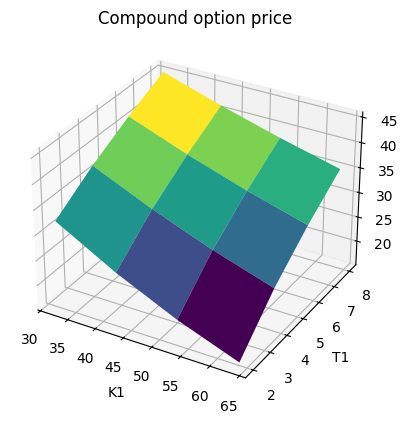

In [28]:
flatten_array = np.array(flatten_array)  

# Создаем сетку для K1 и T1  
K1_values = flatten_array[:, 0]  
T1_values = flatten_array[:, 1]  
prices_values = flatten_array[:, 2]  

K1_grid, T1_grid = np.meshgrid(np.unique(K1_values), np.unique(T1_values))  
  
# массив prices   
prices_grid = np.zeros_like(K1_grid)   
for i, K1 in enumerate(np.unique(K1_values)):  
    for j, T1 in enumerate(np.unique(T1_values)):  
        prices_grid[j, i] = compound_call_price(V0, K1, K2, T1, T2, r, sigma)  
  
# Строим поверхность
fig = plt.figure()  
ax = fig.add_subplot(111, projection='3d')   
ax.plot_surface(K1_grid, T1_grid, prices_grid, cmap='viridis')  
  
# Устанавливаем метки осей  
ax.set_xlabel('K1')  
ax.set_ylabel('T1')  
ax.set_zlabel('Price')  
ax.set_title('Compound option price')

plt.show()  

Поверхность волатильности

В стандартном случае применения мы можем взять рыночную цену опциона